<a href="https://colab.research.google.com/github/pranjalchaubey/Flask-ML-Application/blob/master/prediction_engine/Stock_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Direction
In this notebook we are going to use Random Forests to predict the direction  
of stocks for the next trading day.  
In more technical terms, we are going to try and predict the _**Momentum**_  
of the stocks.  
Based on the momentum, we are going to give the following signals to the user  
1. Buy (_+ve momentum_)
2. Sell (_-ve momentum_)
3. Hold (_neutral_)  

This system will work on the daily closing prices and will generate the signals by predicting the momentum for the next trading day. 

##Setup The Colab Environment 
Install and Import the required libraries.  

In [1]:
# Debug Flag
_GLOBAL_DEBUG_ = True

In [2]:
# Install the yFinance library 
!pip install -q yfinance 

In [3]:
# yFinance will help us fetch the data for our dataset
import yfinance as yf

In [4]:
# Technical Analysis
from ta_functions import *

In [5]:
# Data Mining and plotting 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Classifier 
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import os
import sys
import shutil
# if in Google Colaboratory
try:
    from google.colab import drive
except:
    pass

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Configure Pandas Display Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
# Since I am running this notebook on Colab, 
# Let's try and get some system information 
import platform
print('System Processor: ', platform.processor(), '\n')
!nvidia-smi

System Processor:  i386 

/bin/sh: nvidia-smi: command not found


## Load the Data
We will extract the 5 year history of 10 stocks chosen by the user. 

<br/>Here, we will take the following stocks as an example
1. Facebook FB
2. Apple AAPL
3. Amazon AMZN
4. Netflix NFLX
5. Google GOOGL
6. Starbucks SBUX
7. Exxon Mobil XOM
8. Johnson & Johnson JNJ
9. Bank of America BAC
10. General Motors GM

<br/>In the actual application, stock selection will be done by the user. 

In [10]:
# List of stock tickers 
# this info will come from the user, perhaps in the form of a pickle file 
ticker_list = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'SBUX', 'XOM', 'JNJ',\
               'BAC', 'GM']

In [11]:
def fetch_ticker_data(tickers): 
    """
    Fetch 5 years of historical data for the 'tickers', from Yahoo Finance.    

    Parameters
    ----------
    tickers : List   
        List of stocks chosen by the user.   
        
    Returns
    -------
    data : Dataframe 
        Pandas df with historical stock data time series. 
    """
    # Debug 
    _LOCAL_DEBUG_ = True

    # We are going to get 10 years worth of stock data
    # Generate the required timestamps 
    # t_now = pd.datetime.now().date() - pd.DateOffset(n=1)
    t_now = pd.datetime.now().date()
    t_10_year = (t_now - pd.DateOffset(n=3650)).date()
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(t_now)
        print(t_10_year)

    # Get the Data from Yahoo! Finance
    data = yf.download(tickers, start=t_10_year, end=t_now)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(data.head(20))

    # Data is multi-indexed on the columns 
    # Make it multi-index on the rows, to make it 
    # fit for consumption by the RandomForestClassiffier
    data = data.stack(1) 
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(data.head(20))

    # Drop all the columns except for Adj Close & Volume
    data = data[['Adj Close', 'Volume']]
    # Rename the column names 
    data.columns = ['close', 'volume']  
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(data.head(20))

    return data

In [12]:
# Go fetch! 
dataset = fetch_ticker_data(tickers=ticker_list)

2019-10-09
2009-10-11
[*********************100%***********************]  10 of 10 downloaded


Adj Close                                                           Close                                                             High                                                              Low                                                             Open                                                               Volume                                                                               
                AAPL    AMZN    BAC  FB  GM   GOOGL    JNJ  NFLX  SBUX    XOM   AAPL    AMZN    BAC  FB  GM   GOOGL    JNJ  NFLX   SBUX    XOM   AAPL    AMZN    BAC  FB  GM   GOOGL    JNJ  NFLX   SBUX    XOM   AAPL    AMZN    BAC  FB  GM   GOOGL    JNJ  NFLX   SBUX    XOM   AAPL    AMZN    BAC  FB  GM   GOOGL    JNJ  NFLX   SBUX    XOM       AAPL      AMZN        BAC  FB  GM     GOOGL       JNJ      NFLX      SBUX       XOM
Date                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-10-12     23.79   93.60  16.28 NaN NaN  262.28  46.22  6.58  8.73  51.08  27.26   93.60  18.03 NaN NaN  262.28  62.53  6.58  10.18  70.13  27.36   96.25  18.03 NaN NaN  263.14  62.74  6.83  10.27  70.50  27.09   93.07  17.51 NaN NaN  259.92  61.87  6.57  10.04  69.44  27.29   96.17  17.65 NaN NaN  261.97  61.89  6.71  10.08  69.51   72006200   5591400  139972400 NaN NaN   6637700  12697200   7390600  20038600  16233800
2009-10-13     23.69   94.83  16.08 NaN NaN  263.32  45.09  6.64  8.65  51.17  27.15   94.83  17.81 NaN NaN  263.32  61.01  6.64  10.10  70.26  27.31   95.25  18.00 NaN NaN  263.99  61.40  6.71  10.22  70.39  27.10   93.68  17.48 NaN NaN  260.95  60.63  6.56  10.02  69.52  27.23   93.83  17.94 NaN NaN  262.46  60.92  6.58  10.22  70.25   87005100   4720000  150388900 NaN NaN   6068700  23501200   4514300  13518400  19333400
2009-10-14     23.85   97.46  16.79 NaN NaN  267.93  44.75  6.87  8.80  52.32  27.33   97.46  18.59 NaN NaN  267.93  60.55  6.87  10.27  71.84  27.47   97.82  18.64 NaN NaN  268.06  61.24  6.87  10.36  71.88  27.18   96.02  18.16 NaN NaN  265.27  60.14  6.65  10.16  70.75  27.46   96.22  18.38 NaN NaN  266.50  61.21  6.70  10.22  70.84   93877700   5556800  229813800 NaN NaN   6510200  18951100   7655200  14877000  25285700
2009-10-15     23.76   96.01  16.34 NaN NaN  265.22  45.04  7.19  8.88  53.12  27.22   96.01  18.10 NaN NaN  265.22  60.94  7.19  10.36  72.94  27.27   97.06  19.10 NaN NaN  268.72  60.94  7.28  10.36  73.00  27.08   95.08  17.88 NaN NaN  263.90  60.29  6.75  10.15  71.51  27.09   95.13  18.33 NaN NaN  267.14  60.43  6.75  10.18  71.51   93389100   6242100  212270200 NaN NaN  12188500  14076600  18520600  20286600  24093600
2009-10-16     23.44   95.32  15.59 NaN NaN  275.20  44.69  7.00  8.85  53.25  26.86   95.32  17.26 NaN NaN  275.20  60.46  7.00  10.32  73.12  27.19   96.12  17.49 NaN NaN  277.65  60.71  7.12  10.35  73.35  26.83   93.61  17.06 NaN NaN  272.54  60.25  6.86  10.16  72.31  27.05   95.30  17.16 NaN NaN  273.94  60.57  7.08  10.32  72.73  107856700   7038400  336814500 NaN NaN  17666100  13911200   8269100  20250800  23556600
2009-10-19     23.67   94.68  15.50 NaN NaN  276.32  45.21  7.11  8.98  53.62  27.12   94.68  17.16 NaN NaN  276.32  61.16  7.11  10.47  73.62  27.14   96.28  17.53 NaN NaN  277.08  61.47  7.20  10.56  73.97  26.51   94.25  17.14 NaN NaN  274.64  60.42  7.01  10.24  73.00  26.84   95.35  17.27 NaN NaN  276.62  60.61  7.12  10.34  73.15  235557700   6017400  155876100 NaN NaN   6429300  11443300   5580400  15396600  20404600
2009-10-20     24.78   94.98  15.36 NaN NaN  276.14  44.78  6.99  8.80  53.18  28.39   94.98  17.01 NaN NaN  276.14  60.59  6.99  10.27  73.02  28.82   96.10  

Adj Close   Close    High     Low    Open       Volume
Date                                                                    
2009-10-12 AAPL       23.79   27.26   27.36   27.09   27.29   72006200.0
           AMZN       93.60   93.60   96.25   93.07   96.17    5591400.0
           BAC        16.28   18.03   18.03   17.51   17.65  139972400.0
           GOOGL     262.28  262.28  263.14  259.92  261.97    6637700.0
           JNJ        46.22   62.53   62.74   61.87   61.89   12697200.0
           NFLX        6.58    6.58    6.83    6.57    6.71    7390600.0
           SBUX        8.73   10.18   10.27   10.04   10.08   20038600.0
           XOM        51.08   70.13   70.50   69.44   69.51   16233800.0
2009-10-13 AAPL       23.69   27.15   27.31   27.10   27.23   87005100.0
           AMZN       94.83   94.83   95.25   93.68   93.83    4720000.0
           BAC        16.08   17.81   18.00   17.48   17.94  150388900.0
           GOOGL     263.32  263.32  263.99  260.95  262.46    6068700.0
           JNJ        45.09   61.01   61.40   60.63   60.92   23501200.0
           NFLX        6.64    6.64    6.71    6.56    6.58    4514300.0
           SBUX        8.65   10.10   10.22   10.02   10.22   13518400.0
           XOM        51.17   70.26   70.39   69.52   70.25   19333400.0
2009-10-14 AAPL       23.85   27.33   27.47   27.18   27.46   93877700.0
           AMZN       97.46   97.46   97.82   96.02   96.22    5556800.0
           BAC        16.79   18.59   18.64   18.16   18.38  229813800.0
           GOOGL     267.93  267.93  268.06  265.27  266.50    6510200.0

close       volume
Date                                 
2009-10-12 AAPL    23.79   72006200.0
           AMZN    93.60    5591400.0
           BAC     16.28  139972400.0
           GOOGL  262.28    6637700.0
           JNJ     46.22   12697200.0
           NFLX     6.58    7390600.0
           SBUX     8.73   20038600.0
           XOM     51.08   16233800.0
2009-10-13 AAPL    23.69   87005100.0
           AMZN    94.83    4720000.0
           BAC     16.08  150388900.0
           GOOGL  263.32    6068700.0
           JNJ     45.09   23501200.0
           NFLX     6.64    4514300.0
           SBUX     8.65   13518400.0
           XOM     51.17   19333400.0
2009-10-14 AAPL    23.85   93877700.0
           AMZN    97.46    5556800.0
           BAC     16.79  229813800.0
           GOOGL  267.93    6510200.0

## Data Preprocessing
Now that we have the data downloaded and neatly organized in a dataframe,  
time to do some necessary preprocessing.  
In particular, we are going to use the _log returns_ of the stocks to create a  
target column, called `target`.  
The target variable will be created using the following criteria  
```
  -1 = Sell = ret < -0.0015
   0 = Hold = -0.0015 < ret < 0.0015 
   1 = Buy  = ret > .0015
```

In [13]:
def classify_return(ret):
    """
    Classify the returns as -1, 0 or 1.
    -1 = Sell = ret < -0.0015
    0 = Hold = -0.0015 < ret < 0.0015 
    1 = Buy  = ret > .0015

    Parameters
    ----------
    ret : Float   
        Stock return for the current day, d. 
        retd = log(retd) - log(ret(d-1))

    Returns
    -------
    ret_category : Integer
        Category of return, ret. 
        -1, 0 or 1. 
    """
    ret_category = 0
    
    if ret < -0.0015: 
        ret_category = -1
    elif -0.0015 < ret and ret < 0.0015:
        ret_category = 0
    elif ret > 0.0015:
        ret_category = 1

    return ret_category

In [14]:
def data_preprocess(dataset):
    """
    Calculates log returns and creates the 'target' column.
    Returns the processed dataset as well as the data for the current 
    date separately on which the prediction has to be performed. 

    Parameters
    ----------
    dataset : Pandas Dataframe
        Dataframe containing price, volume and other 
        information of the chosen stocks. 

    Returns
    -------
    dataset: DataFrame
        Processed dataframe with two additional columns,
        'returns' and 'target'. 
        returns = log returns of prices 
        target = target column for the classifier to predict
    pred_data: DataFrame
        Data for the 'current date' on which the trained classifier 
        will perform the prediction. The classifier output from 
        this prediction will be visible to the user. 
    """
    # Debug Flag
    _LOCAL_DEBUG_ = False

    # Advance the prices by 1 day to calculate the log returns 
    dataset['shift'] = dataset.groupby(level=1)['close'].shift(1)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(dataset.head(30))

    # Create the 'returns' column
    dataset['returns'] = np.log(dataset['close']) - np.log(dataset['shift'])
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        #print('Return Head')
        #display(dataset.head(30))
        print('Return Tail')
        display(dataset.tail(30))

    ### Some Technical Analysis Indicators
    # Calculate momentum indicator, RSI score (based on a 10-day period, instead of the usual 14-day one)
    rsi_score(dataset, 10)
    
    # Calculate trend indicator, 'MA_score', using a 20 and 50-day moving average crossover
    ma_score(dataset, 20, 50)
    
    # Calculate volatility indicator, Bollinger Bands score
    bollinger_score(dataset, 20, 2)
    
    # Classify the resulting scores 
    #classify_scores(dataset)
    ### -----END------ ###    
    
    # Drop the first row as it contains NANs in the returns column
    dataset.drop(index = dataset.index.levels[0].values[0], level=0,\
                 inplace=True)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(dataset.head(30))

    # Create the 'target' column for the classifier 
    # Shift the 'target' into the future/delay by 1 day 'shift(-1)'
    # We do this since we are predicting returns of the 'next day close'
    dataset['target'] = dataset['returns'].apply(lambda x: classify_return(x))
    dataset['target'] = dataset.groupby(level=1)['target'].shift(-1)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        #print('Target Head')
        #display(dataset.head(30))
        print('Target Tail')
        display(dataset.tail(30))

    # Drop the 'shift' column as it was only temporary to calculate 'returns'
    dataset.drop(['shift'], axis=1, inplace=True)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(dataset.head(30))

    # Extract the data for the current date, before dropping NANs 
    pred_data = dataset.iloc[-(len(ticker_list)):]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('pred_data')
        display(pred_data)

    # Handle NANs
    # We keep it simple at the moment and simply drop off rows with NANs 
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(dataset.shape)
        print(dataset.isna().sum())
    dataset.dropna(how='any', inplace=True)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(dataset.shape)
        print(dataset.isna().sum())
        print('Final Dataset Tail')
        display(dataset.tail(30))

    return dataset, pred_data

Pre-process the downloaded dataset. 

In [15]:
if _GLOBAL_DEBUG_:
    display(dataset.head(20))
dataset, pred_data = data_preprocess(dataset)
if _GLOBAL_DEBUG_:
    display(dataset.head(20))
    display(dataset.tail())
    display(pred_data)

close       volume
Date                                 
2009-10-12 AAPL    23.79   72006200.0
           AMZN    93.60    5591400.0
           BAC     16.28  139972400.0
           GOOGL  262.28    6637700.0
           JNJ     46.22   12697200.0
           NFLX     6.58    7390600.0
           SBUX     8.73   20038600.0
           XOM     51.08   16233800.0
2009-10-13 AAPL    23.69   87005100.0
           AMZN    94.83    4720000.0
           BAC     16.08  150388900.0
           GOOGL  263.32    6068700.0
           JNJ     45.09   23501200.0
           NFLX     6.64    4514300.0
           SBUX     8.65   13518400.0
           XOM     51.17   19333400.0
2009-10-14 AAPL    23.85   93877700.0
           AMZN    97.46    5556800.0
           BAC     16.79  229813800.0
           GOOGL  267.93    6510200.0

close       volume   returns  RSI_score        RSI     EMA_20     EMA_50  MA_score       BB_hi       BB_lo  BB_score  target
Date                                                                                                                                           
2009-10-14 GOOGL  267.93    6510200.0  0.017356          0  68.993741  71.609126  51.297634         1  247.663144 -105.257144         0    -1.0
           JNJ     44.75   18951100.0 -0.007569          0  46.736897  69.051114  51.040864         1  247.771981 -103.269981         0     1.0
           NFLX     6.87    7655200.0  0.034052          0  43.805419  63.129103  49.308673         1  245.488182 -109.659182         0     1.0
           SBUX     8.80   14877000.0  0.017192          0  44.024057  57.954903  47.720097         1  245.602917 -110.521917         0     1.0
           XOM     52.32   25285700.0  0.022225          0  49.445026  57.418245  47.900486         1  209.709041  -95.624041         0     1.0
2009-10-15 AAPL    23.76   93389100.0 -0.003781          0  45.881099  54.212698  46.953800         1  209.250220  -97.411220         0    -1.0
           AMZN    96.01    6242100.0 -0.014990          0  55.744064  58.193394  48.877573         1  212.877028  -92.095028         0    -1.0
           BAC     16.34  212270200.0 -0.027167          0  44.752023  54.207356  47.601589         1  212.751889  -91.208889         0    -1.0
           GOOGL  265.22   12188500.0 -0.010166          0  68.481576  74.303798  56.135645         1  248.665971 -105.708971        -1     1.0
           JNJ     45.04   14076600.0  0.006460          0  46.763607  71.516770  55.700521         1  248.775881 -103.683881         0    -1.0
           NFLX     7.19   18520600.0  0.045527          0  43.842301  65.390411  53.798148         1  246.407715 -110.079715         0    -1.0
           SBUX     8.88   20286600.0  0.009050          0  44.033098  60.008467  52.036652         1  246.519099 -110.911099         0    -1.0
           XOM     53.12   24093600.0  0.015175          0  49.520372  59.352423  52.079136         1  210.498764  -95.910764         0     1.0
2009-10-16 AAPL    23.44  107856700.0 -0.013560          0  45.835469  55.932192  50.956033         1  210.083828  -97.660828         0     1.0
           AMZN    95.32    7038400.0 -0.007213          0  55.612320  59.683412  52.695796         1  213.611425  -92.320425         0    -1.0
           BAC     15.59  336814500.0 -0.046986          0  44.679015  55.484039  51.240667         1  213.492567  -91.507567         0    -1.0
           GOOGL  275.20   17666100.0  0.036938          0  68.962688  76.409369  60.023386         1  252.104027 -107.716027        -1     1.0
           JNJ     44.69   13911200.0 -0.007801          0  46.711028  73.388476  59.422077         1  252.206034 -105.734034         0     1.0
           NFLX     7.00    8269100.0 -0.026781          0  43.881486  67.065764  57.366309         1  249.666644 -112.240644         0     1.0
           SBUX     8.85   20250800.0 -0.003384          0  44.084686  61.521406  55.463709         1  249.783399 -113.151399         0     1.0

close      volume   returns  RSI_score        RSI      EMA_20      EMA_50  MA_score        BB_hi       BB_lo  BB_score  target
Date                                                                                                                                              
2019-10-07 GOOGL  1208.25    852000.0 -0.002240          0  61.398578  445.763946  415.980736         1  1537.501919 -742.962919         0    -1.0
           JNJ     133.16   5427200.0 -0.003748          0  45.716244  415.992142  404.889727         1  1537.503974 -742.767974         0    -1.0
           NFLX    274.46   6525600.0  0.006103          0  47.855716  402.512890  399.774836         1  1537.672400 -742.305400         0    -1.0
           SBUX     85.85   4382900.0 -0.000815          0  44.964509  372.354520  387.464058        -1  1537.663309 -742.178309         0    -1.0
           XOM      68.02  10993000.0 -0.013870          0  44.652813  343.370280  374.936840        -1  1537.662873 -742.173873         0    -1.0

close      volume   returns  RSI_score        RSI      EMA_20      EMA_50  MA_score        BB_hi       BB_lo  BB_score  target
Date                                                                                                                                              
2019-10-08 AAPL    224.40  27955000.0 -0.011784          0  48.481128  332.039777  369.033434        -1  1537.615267 -742.387267         0     NaN
           AMZN   1705.51   2542000.0 -0.015794         -1  71.389488  462.846465  421.444280         1  1527.518498 -735.704498        -1     NaN
           BAC      27.63  58201100.0 -0.024313          0  44.185554  421.397278  406.000583         1  1527.532144 -735.792144         0     NaN
           FB      177.75   9466900.0 -0.010799          0  46.418312  398.192775  397.049579         1  1527.505986 -736.035986         0     NaN
           GM       33.88  10686900.0 -0.025355          0  44.340631  363.496320  382.807635        -1  1527.523710 -736.156710         0     NaN
           GOOGL  1190.13   1004300.0 -0.015110          0  61.338645  442.223337  414.467336         1  1523.357480 -734.073480         0     NaN
           JNJ     131.84   7870400.0 -0.009962          0  45.719306  412.663019  403.383911         1  1523.355364 -734.253364         0     NaN
           NFLX    270.72   6276400.0 -0.013720          0  47.849278  399.144637  398.181405         1  1523.299250 -734.404250         0     NaN
           SBUX     84.91   6100400.0 -0.011010          0  44.964091  369.217528  385.896251        -1  1523.306953 -734.512953         0     NaN
           XOM      66.70   9748700.0 -0.019597          0  44.641665  340.406335  373.378751        -1  1523.331663 -734.764663         0     NaN

## Feature Engineering 
Leaving this section blank at the moment. Will come back at a later time. 

## Train Test Split 
Split the data into testing and training sets.  
In production, there's going to be only re-training of the model that we have  
chosen with the specified hyper-parameters. 

In [16]:
def train_test_split(dataset, features, target, train_size, test_size):
    """
    Generate the train and test dataset.

    Parameters
    ----------
    dataset : DataFrame
        All the samples including target
    features : List
        List of the names of columns that are features
    target : String
        Name of column that is the target (in our case, 'target')
    train_size : float
        The proportion of the data used for the training dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_test : Pandas Series
        The test target values
    """
    # Data Sanity check 
    assert train_size >= 0 and train_size <= 1.0, 'Train size out of bounds!'
    assert test_size >= 0 and test_size <= 1.0, 'Test size out of bounds!'
    assert train_size + test_size == 1.0, 'Train + Test should be equal to 1!'
    
    # Debug Flag 
    _LOCAL_DEBUG_ = True 
    
    # Extract the x and y from the dataset
    all_x = dataset[features]
    all_y = dataset[target]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(all_x.head())
        print(all_y.head())
        print('dataset.shape ', dataset.shape)

    # Get the number of rows in df and no of elements in the pandas series 
    # NOTE - Both are multi-indexed
    len_x = len(all_x.index.levels[0])
    len_y = len(all_y.index.levels[0])
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('Len x ', len_x)
        print('Len y ', len_y)
    
    # Some fancy calculations here for x
    x_train = all_x.loc[all_x.index.levels[0]\
                        [:int(len_x*train_size)].astype(str).tolist()]
    x_test = all_x.loc[all_x.index.levels[0]\
                       [int(len_x*train_size):int(len_x*train_size) + int(len_x*test_size)]\
                       .astype(str).tolist()]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('x_train.shape ', x_train.shape)
        print('x_test.shape ', x_test.shape)

    # Some fancy calculations here for y as well
    y_train = all_y.loc[all_y.index.levels[0]\
                        [:int(len_y*train_size)].astype(str).tolist()]
    y_test = all_y.loc[all_y.index.levels[0]\
                       [int(len_y*train_size):int(len_y*train_size) + int(len_y*test_size)]\
                       .astype(str).tolist()]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('y_train.shape ', y_train.shape)
        print('y_test.shape ', y_test.shape)
 
    return x_train, x_test, y_train, y_test 

In [17]:
# In our dataset all the columns except for the 'target' column are features
# Temporarily drop the 'target' and extract the features  
features = dataset.drop(['target'], axis=1).columns.values.tolist()

# Get the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(dataset=dataset,\
                                                    features=features,\
                                                    target='target',\
                                                    train_size=0.9,\
                                                    test_size=0.1)

                   close      volume   returns  RSI_score        RSI     EMA_20     EMA_50  MA_score       BB_hi       BB_lo  BB_score
Date                                                                                                                                  
2009-10-14 GOOGL  267.93   6510200.0  0.017356          0  68.993741  71.609126  51.297634         1  247.663144 -105.257144         0
           JNJ     44.75  18951100.0 -0.007569          0  46.736897  69.051114  51.040864         1  247.771981 -103.269981         0
           NFLX     6.87   7655200.0  0.034052          0  43.805419  63.129103  49.308673         1  245.488182 -109.659182         0
           SBUX     8.80  14877000.0  0.017192          0  44.024057  57.954903  47.720097         1  245.602917 -110.521917         0
           XOM     52.32  25285700.0  0.022225          0  49.445026  57.418245  47.900486         1  209.709041  -95.624041         0
Date             
2009-10-14  GOOGL   -1.0
            

## Hyperparameter Search
We have the dataset in our hand with train and test splits.  
Time to train our _Random Forest Classifier_, and look for the best set of  
hyperparameters.  

1. Create a plotting function to help in evaluating the performance of RFCs  
2. Display the ranked feature importances 
3. Declare a hyperparameter _'grid'_ for the various RFCs to train on
4. Train the RFCs 
5. Based on performance, choose the best set of hyperparameters. 

In [18]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    """
    Generate a plot of xs vs ys.

    Parameters
    ----------
    xs : List
        List of x-axis values  
    ys : List
        List of y-axis values  
    labels : List
        List of strings containing the name of legends
    title : String
        Plot Title
    x_label : String
        Name of the x-axis
    y_label : String
        Name of the y-axis

    Returns
    -------
    None. Just plots the plot.
    """
    # Set the figure size
    plt.rcParams['figure.figsize'] = [12, 6]

    # Build the plots
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.4, 0.7))
        plt.plot(x, y, label=label)

    # Set the titles and lables 
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Align the legends and show the plot 
    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

    return None

In [19]:
def rank_features_by_importance(importances, feature_names):
    """
    Ranks and Pretty prints the feature importances as 
    evaluated by the Random Forest Classifier. 

    Parameters
    ----------
    importances : ndarray
        A numpy array containing feature importance values  
    feature_names : List
        A list of strings containing the names of features

    Returns
    -------
    None. Just ranks and pretty prints the features along 
    with their importance. 
    """
    # Get the sorted INDEX of the importances array 
    indices = np.argsort(importances)[::-1]
    # Use this parameter to align the print output
    max_feature_name_length = max([len(feature) for feature in feature_names])

    # Pretty Print the ranked features and their respective importances 
    for x_train_i in range(len(importances)):
        print('{number:>2}. {feature: <{padding}} ({importance})'.format(
            number=x_train_i + 1,
            padding=max_feature_name_length,
            feature=feature_names[indices[x_train_i]],
            importance=importances[indices[x_train_i]]))

    return None

In [20]:
# Hyperparameters 
# This is to get consistent results between each run.
clf_random_state = 0

n_days = 5
n_stocks = len(ticker_list)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [5, 10, 25, 50, 75, 100]

In [21]:
# %%timeit -n 1 -r 1
# Train the Classifier 
train_score = []
test_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    # Train 
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    # Performance Parameters 
    train_score.append(clf.score(X_train, y_train.values))
    test_score.append(clf.score(X_test, y_test.values))
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 6/6 [00:05<00:00,  1.07Model/s]


Features Ranked by Average Importance:

 1. close     (0.13857427352464755)
 2. volume    (0.13750959121481274)
 3. returns   (0.12796951123234537)
 4. BB_hi     (0.12690010492677709)
 5. BB_lo     (0.12364922706904685)
 6. RSI       (0.12185332568878467)
 7. EMA_50    (0.10962420382930284)
 8. EMA_20    (0.10506982000109534)
 9. MA_score  (0.007040330880219076)
10. BB_score  (0.0013692830546589072)
11. RSI_score (0.00044032857830948063)


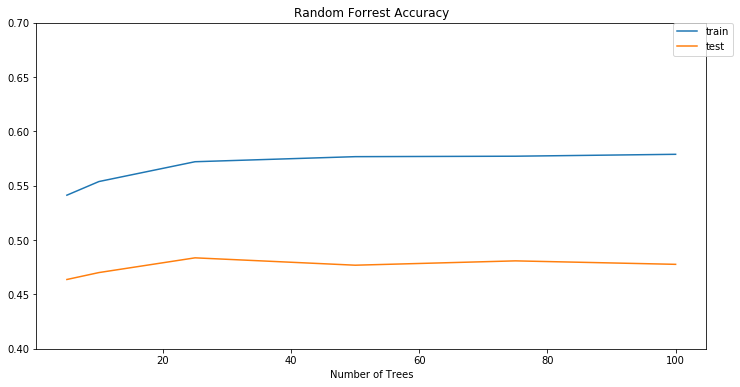

In [22]:
# The most important features 
print('Features Ranked by Average Importance:\n')
rank_features_by_importance(np.average(feature_importances, axis=0), features)

# Visualize the performance of the various classifiers 
plot([n_trees_l]*3,
    [train_score, test_score],
    ['train', 'test'],
    'Random Forrest Accuracy',
    'Number of Trees')

## Train the Best Model 
From the above set of Random Forests Classifiers, we can observe that the RFC  
with 25 trees has performed the best.  
Notice how the performance on the Testing Set _bumps up_ for the RFC with 25  
tress, and then continues going down for RFCs having higher number of trees.  
Let's train this model (again) and use it for predictions.  
<br/>
_**However, there's not going to be any test set this time. We will use all  
the data to train our model and make a prediction for the next trading day.**_  

In [23]:
# Get the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(dataset=dataset,\
                                                    features=features,\
                                                    target='target',\
                                                    train_size=1.0,\
                                                    test_size=0.0)

                   close      volume   returns  RSI_score        RSI     EMA_20     EMA_50  MA_score       BB_hi       BB_lo  BB_score
Date                                                                                                                                  
2009-10-14 GOOGL  267.93   6510200.0  0.017356          0  68.993741  71.609126  51.297634         1  247.663144 -105.257144         0
           JNJ     44.75  18951100.0 -0.007569          0  46.736897  69.051114  51.040864         1  247.771981 -103.269981         0
           NFLX     6.87   7655200.0  0.034052          0  43.805419  63.129103  49.308673         1  245.488182 -109.659182         0
           SBUX     8.80  14877000.0  0.017192          0  44.024057  57.954903  47.720097         1  245.602917 -110.521917         0
           XOM     52.32  25285700.0  0.022225          0  49.445026  57.418245  47.900486         1  209.709041  -95.624041         0
Date             
2009-10-14  GOOGL   -1.0
            

In [24]:
# Train the Random Forest Classifier on this data 
# We have selected n_trees to be 25
n_trees = 25
clf = RandomForestClassifier(n_trees, **clf_parameters)
clf.fit(X_train, y_train)
# Get the Training score (just for us)
print(f'Classifier Accuracy: {clf.score(X_train, y_train.values):0.3f}')

Classifier Accuracy: 0.573


## Make the Prediction
Now that we have trained our model with the best set of hyperparameters, time  
to make the prediction for the next date (that is tomorrow's close).  
The output from this prediction will be shown to the user. 

In [25]:
def make_prediction(pred_data, features, rfc_classifier):
    """
    Makes a price prediction on the stocks as selected by the user. 
    
    Parameters
    ----------
    pred_data : Dataframe
        This dataframe contains only 1 date, today's date (or yesterday's if 
        the markets haven't close yet). The data on this date will be used to 
        make a prediction about the closing prices for next day/tomorrow.
    feature : List
        List of features present in pred_data. It also has a 'target' column, 
        we wont be using it. 
    rfc_classifier : Random Forest Classifier Object 
        Trained Random forest classifier with the best hyperparameters  

    Returns
    -------
    pred_list: List 
        List containing tuples in the following format, 
        [(Stock1, Pred1), (Stock2, Pred2),........]
    """
    # Make the prediction 
    prediction = rfc_classifier.predict(pred_data[features])
    # Create the 'Prediction List' 
    pred_list = [(stock, pred) for stock, pred in\
                 zip(pred_data.index.levels[1].values.tolist(), prediction)]

    return pred_list

In [26]:
final_prediction = make_prediction(pred_data=pred_data, features=features,\
                                   rfc_classifier=clf)

In [27]:
final_prediction

[('AAPL', 1.0),
 ('AMZN', 1.0),
 ('BAC', 1.0),
 ('FB', 1.0),
 ('GM', 1.0),
 ('GOOGL', 1.0),
 ('JNJ', 1.0),
 ('NFLX', 1.0),
 ('SBUX', 1.0),
 ('XOM', 1.0)]